# **任务8 卷积图像分割 CNN Image Segmentation**

图像分割是另一个经典的视觉任务，YOLO同样拥有成熟的方案解决这个问题，但分割任务引入的编解码器思想对后续的很多任务都很有帮助。

___

## 1. **新的层结构**

### **torch二维反卷积层**
先前任务中我们使用池化层，例如最大池化：`nn.MaxPool2d()`，它的作用是压缩特征，通常表现为特征图的宽度和高度维度的缩小，这中维度变化对于分类和回归任务往往没有很大影响，因为后续的线性映射层可以将任何维度的向量重新映射成我们需要的输出维度。

但对于分割任务，我们通常需要生成一个与原图大小相同的蒙版作为分割结果，所以需要将其反向扩大特征图，如果使用线性层直接映射再将一维特征张量变形回二维张量会像最初的线性图像任务一样忽略其空间信息，所以出现了这种结构用于反向扩大其维度。我们通常将压缩特征图大小并且扩大通道维度的过程称为编码，将扩大特征图大小并且减少通道维度的过程称为解码。

### **使用方法**

它同样来自于 `torch` 的 `nn` 子类中，`nn.ConvTranspose2d(input_dim, output_dim, kernel_size=ks, stride=st)`
我们通常使用`kernel_size=2`, `stride=2`作为默认参数，它能二倍放大特征图，与池化层的缩小倍率相同，便于推导需要几层。

In [121]:
import torch
import torch.nn as nn

batch_size = 4
input_tensor = torch.rand((batch_size, 64, 16, 16))

conv_decoder = nn.Sequential(
    nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
    nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)
)
output_tensor = conv_decoder(input_tensor)
print('输入张量：', input_tensor.shape)
print('输出张量：', output_tensor.shape)

输入张量： torch.Size([4, 64, 16, 16])
输出张量： torch.Size([4, 1, 64, 64])


## 2. **定义模型**


In [122]:
class Model(nn.Module):
    def __init__(self, input_channels=3, num_classes=2):
        super(Model, self).__init__()
        # 编码器部分：用于下采样和特征提取
        self.encoder = nn.Sequential(
            # dilation空洞卷积增加感受域
            nn.Conv2d(input_channels, 64, 3, padding=1, dilation=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        # 解码器部分：用于上采样和恢复图像尺寸
        self.decoder = nn.Sequential(
            # 反卷积
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, num_classes, 2, stride=2),
        )

    def forward(self, x):
        # 前向传播时，先通过编码器进行特征提取和下采样
        x = self.encoder(x)
        # 然后通过解码器进行上采样和恢复图像尺寸
        x = self.decoder(x)
        return x

这里使用了 `nn.Sequential()` 方法用于打包一些有固定流程的前向传播层数，让它们逐个执行。

卷积神经网络同样可以使用激活函数增加非线性。

输出层 `output_layer` 的输入维度通常需要冗长的推算，实际使用可以先断点测试。

## 3. **数据生成**

输入数据形状: torch.Size([640, 3, 96, 96])
输入批次数量: 10 	批次形状: torch.Size([64, 3, 96, 96])
标签数据形状: torch.Size([640, 1, 96, 96])
输入批次数量: 10 	批次形状: torch.Size([64, 1, 96, 96])


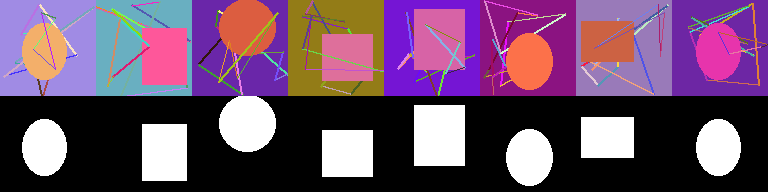

In [123]:
import random
from PIL import Image, ImageDraw
import torchvision.transforms as transforms


def draw_c(img, mid, w, h, col):
    w_img, h_img = img.size
    draw = ImageDraw.Draw(img)
    bounding_box = (mid[0] - w, mid[1] - h, mid[0] + w, mid[1] + h)

    mask = Image.new('L', (w_img, h_img), 0)
    draw_m = ImageDraw.Draw(mask)
    if random.randint(0, 3) % 2 == 0:
        draw.ellipse(bounding_box, fill=col, outline=col, width=1)  # outline 是轮廓颜色，width 是轮廓宽度
        draw_m.ellipse(bounding_box, fill='white', outline='white', width=1)  # outline 是轮廓颜色，width 是轮廓宽度
    else:
        draw.rectangle(bounding_box, fill=col, outline=col, width=1)  # outline 是轮廓颜色，width 是轮廓宽度
        draw_m.rectangle(bounding_box, fill='white', outline='white', width=1)  # outline 是轮廓颜色，width 是轮廓宽度
    return img, mask

def get_data(data_size, img_size, get_all_img=False):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),  # 将图像和掩码调整为相同大小，这里示例尺寸设为256x256，可调整
        transforms.ToTensor()  # 转换为张量
    ])

    train_images = []
    # 用于存储对应类别标签的列表
    train_masks = []
    show_img_list = []
    show_mask_list = []
    img_w, img_h = img_size, img_size
    for num in range(data_size):
        target_col = (random.randint(200, 255), random.randint(50, 200), random.randint(50, 180))
        bg_col = (random.randint(80, 160), random.randint(10, 180), random.randint(20, 250))

        mid_rand = random.randint(25, img_w - 25), random.randint(25, img_h - 25)
        w, h = random.randint(20, 30), random.randint(20, 30)
        # 创建一个新的图像，背景为白色
        img = Image.new('RGB', (img_w, img_h), bg_col)

        point_list = []
        for x in range(10):
            point = random.randint(0, img_w), random.randint(0, img_h)
            point_list.append(point)
        draw = ImageDraw.Draw(img)
        for _ in range(-1, len(point_list) - 1):
            l_col = (random.randint(50, 255), random.randint(5, 255), random.randint(5, 255))
            point1 = point_list[_]
            point2 = point_list[_ + 1]
            draw.line([point1, point2], fill=l_col, width=2)

        img, mask = draw_c(img, mid_rand, w, h, target_col)

        if len(show_img_list) < 8 or get_all_img:
            show_img_list.append(img)
            show_mask_list.append(mask)

        point_list = []
        for x in range(4):
            point = random.randint(0, img_w), random.randint(0, img_h)
            point_list.append(point)
        draw = ImageDraw.Draw(img)
        for _ in range(-1, len(point_list) - 1):
            l_col = (random.randint(50, 255), random.randint(5, 255), random.randint(5, 255))
            point1 = point_list[_]
            point2 = point_list[_ + 1]
            draw.line([point1, point2], fill=l_col, width=random.randint(1, 2))

        img = transform(img)
        mask = transform(mask)

        train_images.append(img)
        train_masks.append(mask)

    # 转换为张量
    train_images, train_masks = torch.stack(train_images), torch.stack(train_masks)
    return train_images, train_masks, (show_img_list, show_mask_list)

# 划分批次
def split_batch(data, batch_size):
    # 核心操作：沿第一个维度（dim=0）分割，保留后续所有维度
    split_tensors = torch.split(data, batch_size, dim=0)
    # 转为列表返回（torch.split返回tuple，列表更易操作）
    return list(split_tensors)

# 训练数据
img_size = 96
batch_size = 64
train_x, train_y, (show_img_list, show_mask_list) = get_data(640, img_size)
train_x_batch = split_batch(train_x, batch_size)
train_y_batch = split_batch(train_y, batch_size)
# 验证数据
val_x, val_y, _ = get_data(32, img_size)
# 测试数据
test_x, test_y, (test_img, test_mask) = get_data(6, img_size, get_all_img=True)
print('输入数据形状:', train_x.shape)
print('输入批次数量:', len(train_x_batch), '\t批次形状:', train_x_batch[0].shape)
print('标签数据形状:', train_y.shape)
print('输入批次数量:', len(train_y_batch), '\t批次形状:', train_y_batch[0].shape)

m = 0
combined = Image.new('RGB', (img_size*len(show_img_list), img_size * 2))
for img in show_img_list:
    combined.paste(img, (m, 0))    # 把a贴到画布左侧
    m += img_size
m = 0
for img in show_mask_list:
    combined.paste(img, (m, img_size))    # 把a贴到画布左侧
    m += img_size
combined

## 4. 模型训练

### 4.1 实例化模型、损失函数、优化器

分割任务的本质也是一个分类任务，分类目标是一整张图像的每个像素 `nn.CrossEntropyLoss()`。

此时以通道数为类别维度，也就是两个类别需要两个通道维度分别代表每个类别的概率得分，每个像素都有一个这样的概率得分。

In [124]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Model(3, 2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### 4.2 **迭代训练**

还记得我们的交叉熵损失的使用规则，只需要一个批次维度，数值代表具体类别的索引。

对于图像分割任务，它的类别索引是二维的，所以除了批次维度还需要宽高维度以对应每个像素，但是此时通道维度就是多余的了。

由于我们的蒙版本身是一个灰度图像，灰度图像只有一个通道维度，可以使用 `squeeze` 方法直接将其去除。

In [125]:
epochs = 16
for epoch in range(epochs):
    loss = None
    model.train()
    for i in range(len(train_x_batch)):
        x = train_x_batch[i].to(device)
        y = train_y_batch[i].to(device)
        # 去除通道维度
        y = y.squeeze(1).long()
        # 前向传播，得到预测值
        output = model(x)
        # 计算损失
        loss = criterion(output, y)
        # 梯度清零，因为在每次反向传播前都要清除之前累积的梯度
        optimizer.zero_grad()
        # 反向传播，计算梯度
        loss.backward()
        # 更新权重和偏置
        optimizer.step()

    val_x = val_x.to(device)
    val_y = val_y.to(device)
    val_y = val_y.squeeze(1).long()
    model.eval()
    output = model(val_x)
    val_loss = criterion(output, val_y).item()

    # 更改验证逻辑为适合分类任务的准确率和召回率
    if (epoch + 1) % 2 == 0:
        print(f'[epoch {epoch+1}]loss:', loss.item())
        print(f'\t val loss:', val_loss)


[epoch 2]loss: 0.3769287168979645
	 val loss: 0.3325917720794678
[epoch 4]loss: 0.14370612800121307
	 val loss: 0.12747980654239655
[epoch 6]loss: 0.12609654664993286
	 val loss: 0.09999334067106247
[epoch 8]loss: 0.07609818875789642
	 val loss: 0.07347115129232407
[epoch 10]loss: 0.06723697483539581
	 val loss: 0.06393963098526001


### 4.3 **测试模型**

使用 `model.eval()` 将模型改为测试模式，避免自动的梯度计算增加额外的计算量。

使用 `torch.argmax()` 将概率得分向量转换为类别索引。

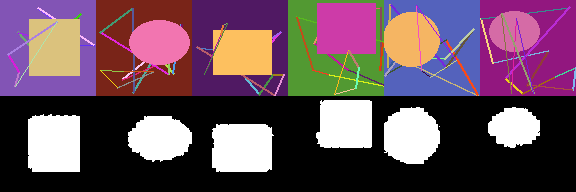

In [126]:
model.eval()
test_x = test_x.to(device)
output = model(test_x)

m = 0
combined = Image.new('RGB', (img_size*len(test_x), img_size * 2))
for i in range(len(test_x)):
    img = test_img[i]
    combined.paste(img, (m, 0))    # 把a贴到画布左侧
    predicted_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # 获取预测的掩码，将张量转换为 numpy 数组
    predicted_mask_image = Image.fromarray(predicted_mask[i].astype('uint8') * 255)  # 将类别索引转换为 0 或 255
    combined.paste(predicted_mask_image, (m, img_size))    # 把a贴到画布左侧
    m += img_size

combined

## 5. **总结**

分割任务提到的卷积编解码器是UNet框架的基础，除了分割任务还可用于生图。